### Data Science Problem Statement


- Predict if the client will subscribe to a term deposit based on the analysis of the marketing campaigns the bank performed.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

##### 1) Data Loading and cleaning

In [3]:
path_train      #Contains path of the train file

In [65]:
# Load the dataframe
dataframe = pd.read_csv(path_train)

# Remove the Id column from the dataset
dataframe.drop('Id',axis=1,inplace=True)

print('Shape of the data is: ',dataframe.shape)

dataframe.head()

Shape of the data is:  (32950, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1.7,94.215,-40.3,0.870,4991.6,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,no


##### 2) Check numeric and categorical feature

In [66]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=np.number).columns.tolist()
    return dataset[numeric_col].head()

numeric_columns = numeric_features(dataframe)
print("Numeric Features:")
print(numeric_columns)
print("===="*20)



# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=np.number).columns.tolist()
    return dataset[categorical_col].head()

categorical_columns = categorical_features(dataframe)
print("Categorical Features:")
print(categorical_columns)


# Function to check the datatypes of all the columns:
def check_datatypes(dataset):
    
    return dataset.dtypes


check_datatypes(dataframe)

Numeric Features:
   age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   49       227         4    999         0          -0.1          93.200   
1   37       202         2    999         1          -0.1          93.200   
2   78      1148         1    999         0          -1.7          94.215   
3   36       120         2    999         0           1.1          93.994   
4   59       368         2    999         0          -2.9          92.963   

   cons.conf.idx  euribor3m  nr.employed  
0          -42.0      4.120       5195.8  
1          -42.0      4.120       5195.8  
2          -40.3      0.870       4991.6  
3          -36.4      4.857       5191.0  
4          -40.8      1.262       5076.2  
Categorical Features:
            job   marital          education  default housing loan    contact  \
0   blue-collar   married           basic.9y  unknown      no   no   cellular   
1  entrepreneur   married  university.degree       no      no   no  telephone

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

##### 3) Check missing data

In [67]:
# Function to identify the number of missing values in every feature
def missing_data(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
    
missing_data = missing_data(dataframe)
print(missing_data)

                Total  Percent
y                   0      0.0
day_of_week         0      0.0
job                 0      0.0
marital             0      0.0
education           0      0.0
default             0      0.0
housing             0      0.0
loan                0      0.0
contact             0      0.0
month               0      0.0
duration            0      0.0
nr.employed         0      0.0
campaign            0      0.0
pdays               0      0.0
previous            0      0.0
poutcome            0      0.0
emp.var.rate        0      0.0
cons.price.idx      0      0.0
cons.conf.idx       0      0.0
euribor3m           0      0.0
age                 0      0.0


##### 4) Check for Class Imbalance

- Class imbalance occurs when the observations belonging to one class in the target are significantly higher than the other class or classes. A class distribution of 80:20 or greater is typically considered as an imbalance for a binary classification.
- Since most machine learning algorithms assume that data is equally distributed, applying them on imbalanced data often results in bias towards majority classes and poor classification of minority classes. Hence we need to identify & deal with class imbalance.

In [68]:
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(dataframe['y'])

no     88.734446
yes    11.265554
Name: y, dtype: float64

> Observations : 
- This is the clear indication of class imbalance.

##### 5) Detect outliers in the continuous columns

- One method of defining outliers are: outliers are data points lying beyond (third quartile + 1.5xIQR) and below (first quartile - 1.5xIQR).

In [69]:
# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns=['Feature','Number of Outliers'])
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            # first quartile (Q1)
            q1 = dataframe[column].quantile(0.25) 
            
            # third quartile (Q3)
            q3 = dataframe[column].quantile(0.75)
            
            # IQR
            iqr = q3 - q1
            
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column,'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(dataframe)

,Feature,Number of Outliers
0,age,368
1,duration,2366
2,campaign,1916
3,pdays,1226
4,previous,4534
5,emp.var.rate,0
6,cons.price.idx,0
7,cons.conf.idx,359
8,euribor3m,0
9,nr.employed,0


##### 6) EDA & Data Visualizations

###### a) Univariate analysis of Categorical columns

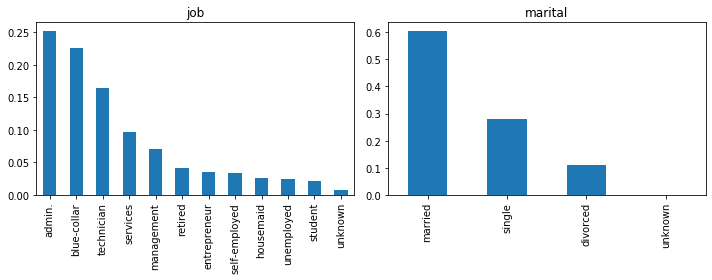

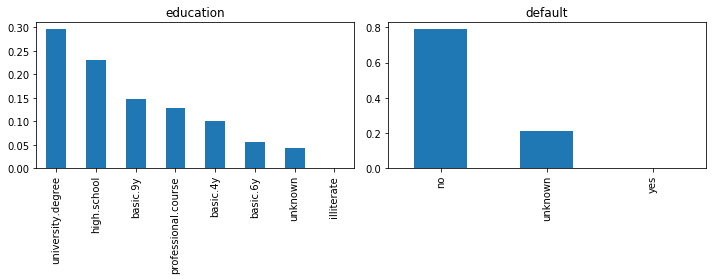

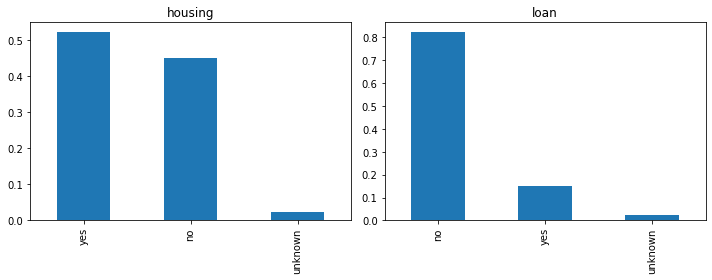

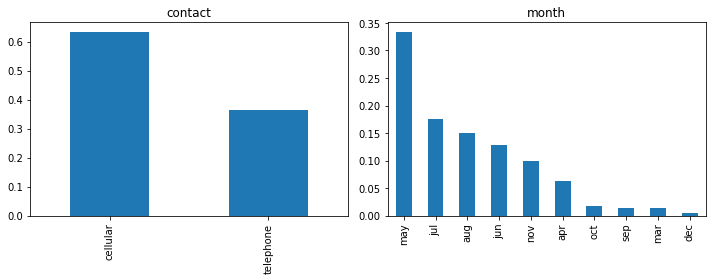

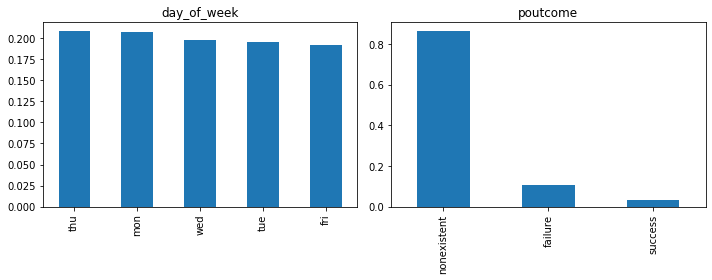

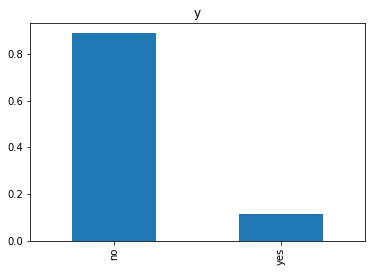

In [70]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object']).columns
    
    for i in range(0,len(categorical_columns),2):
            if len(categorical_columns) > i+1:
                
                plt.figure(figsize=(10,4))
                plt.subplot(121)
                dataframe[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar')
                plt.title(categorical_columns[i])
                plt.subplot(122)     
                dataframe[categorical_columns[i+1]].value_counts(normalize=True).plot(kind='bar')
                plt.title(categorical_columns[i+1])
                plt.tight_layout()
                plt.show()

            else:
                dataframe[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar')
                plt.title(categorical_columns[i])
        
        
        
        
plot = plot_categorical_columns(dataframe)

> Observations:
- Top three professions : Admins, blue-collar and technicians.
- Huge number of customers are marries
- Max number of customers do not have credit in default
- Customers applying for Housing Loan is more as compared to personal loan
- Favoured method to contact : Cellular
- Huge number of customers have been contacted in May
- Target variable is imbalance
- There is unknown in few columns which represent missing values.
 

###### b) Imputing unknown values of categorical columns

In [71]:
# Impute mising values of categorical data with mode
def impute_mode(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(exclude=np.number).columns:
            dataframe[col]=dataframe[col].str.replace('unknown',dataframe[col].mode()[0])
    return dataframe

dataframe = impute_mode(dataframe)

###### c) Univariate analysis of Continuous columns

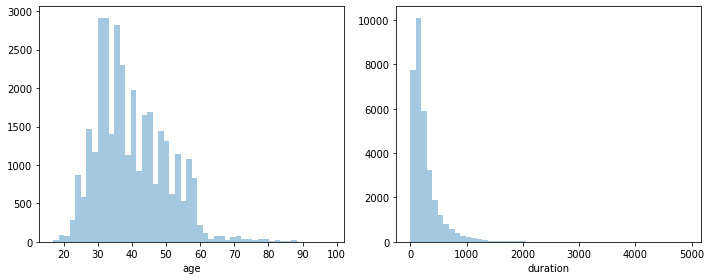

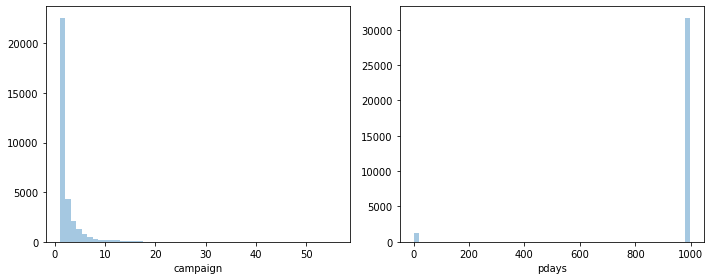

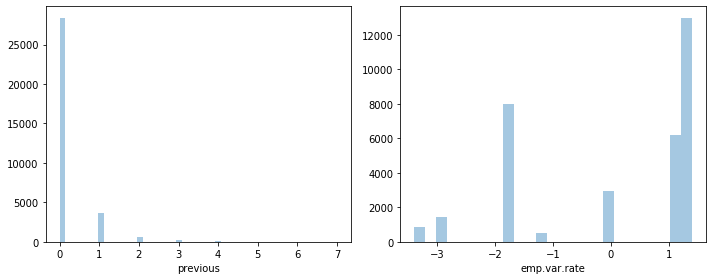

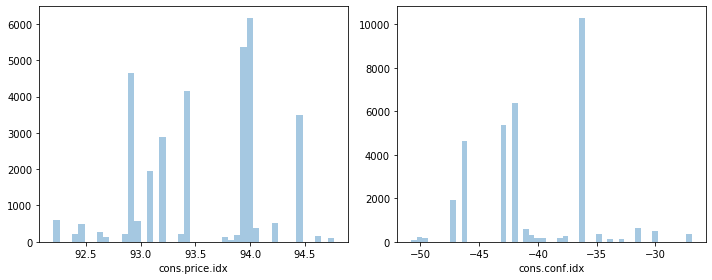

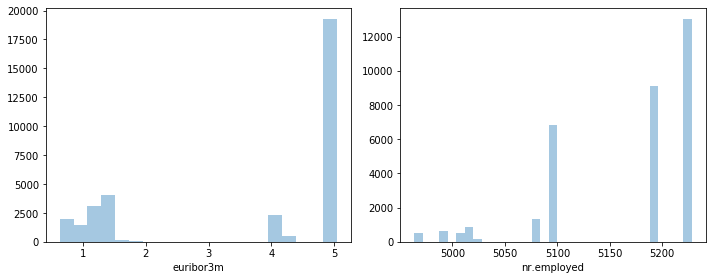

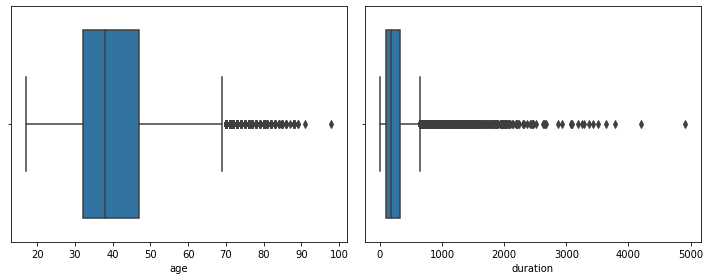

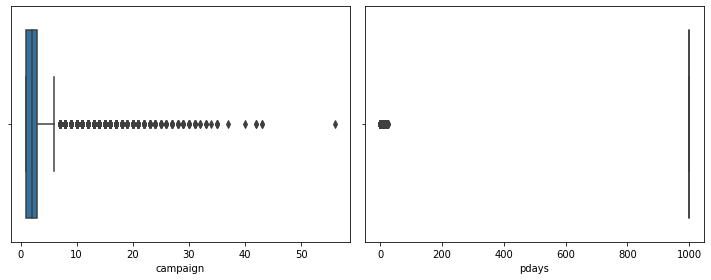

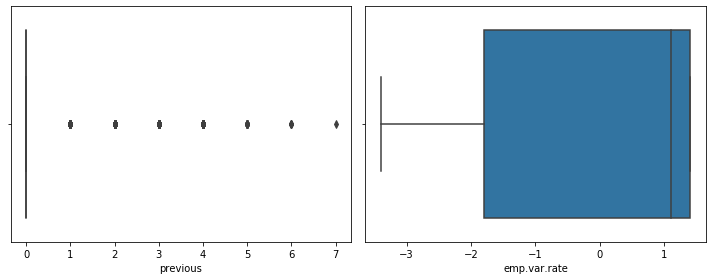

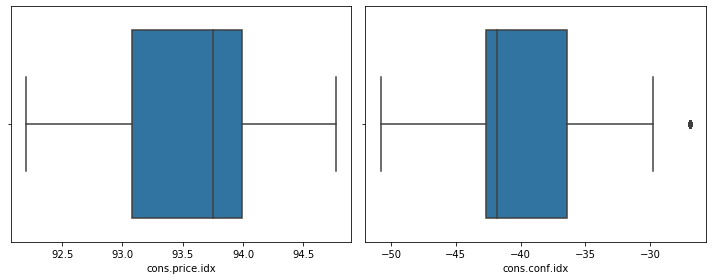

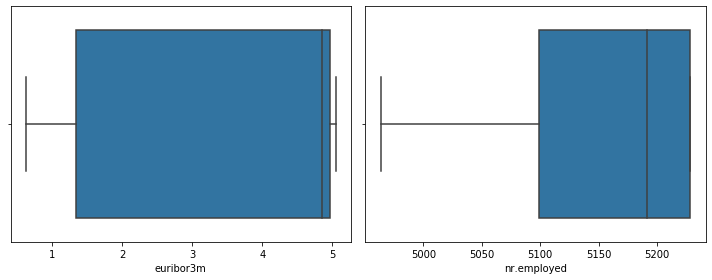

In [72]:
# Function to plot histograms
def plot_continuous_columns(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots
def plot_box_plots(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

plot_continuous_columns(dataframe)            
plot_box_plots(dataframe)

> Observations:
- Features age, duration and campaign are heavily skewed due to outliers.
- pdays and previous consists of majority of only one value and hence we can drop them as variables without any variation are not variables but constant.

###### d) Dropping the columns pdays & previous

In [73]:
dataframe.drop(['pdays','previous'],1,inplace=True)

###### e) Bivariate Analysis - Categorical Columns

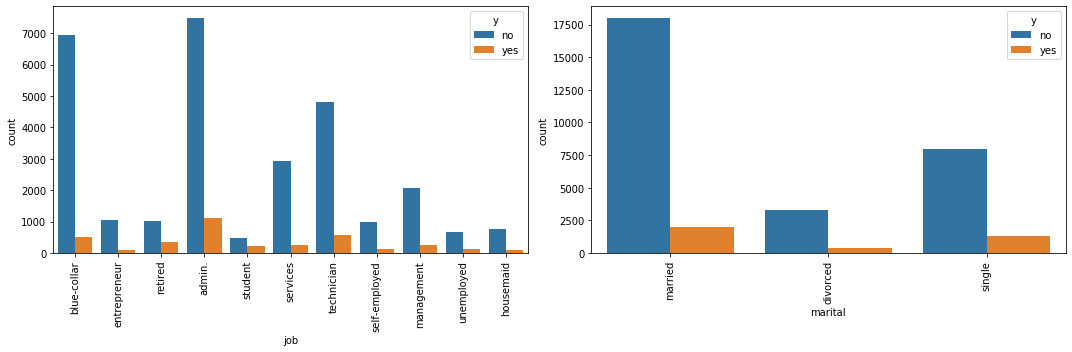

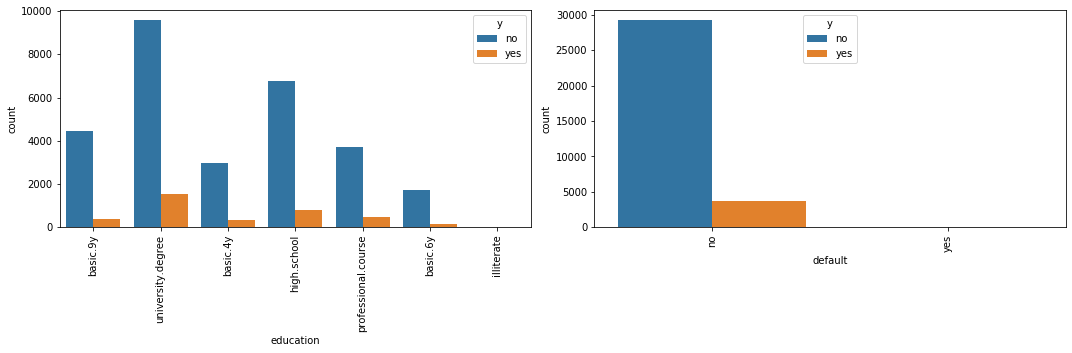

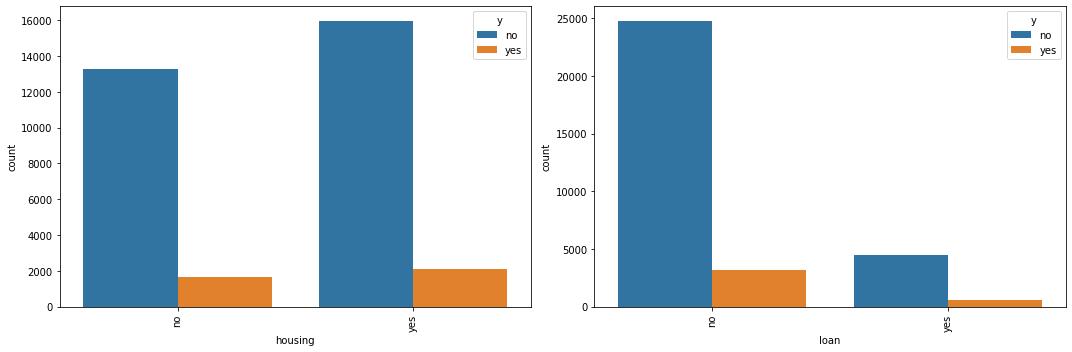

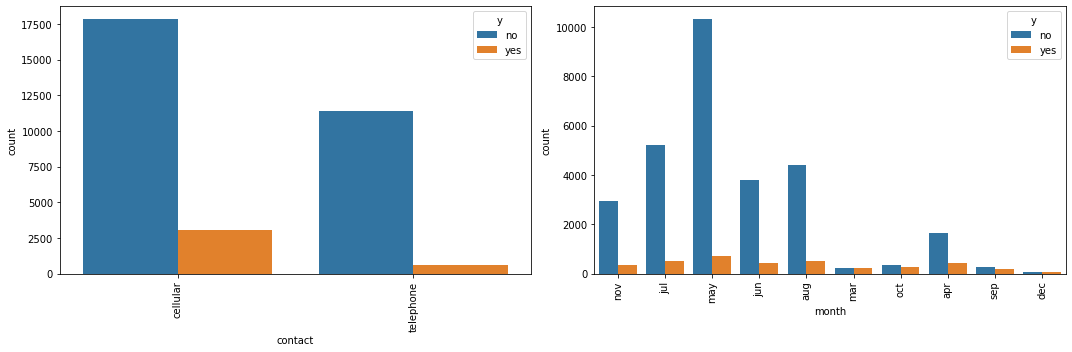

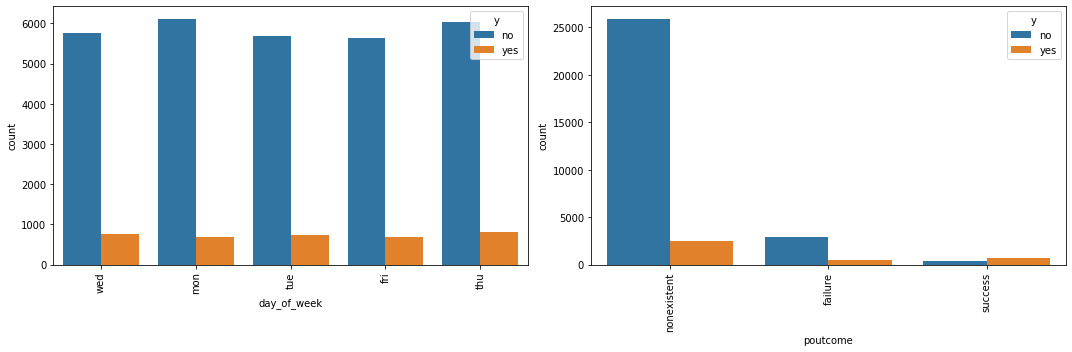

In [74]:
def bivariate_analysis_categorical(dataframe,target):
    categorical_columns = dataframe.select_dtypes(exclude=np.number).columns
    for i in range(0,len(categorical_columns),2):
        if len(categorical_columns) > i+1:
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            sns.countplot(x=dataframe[categorical_columns[i]],hue=target,data=dataframe)
            plt.xticks(rotation=90)
            plt.subplot(122)            
            sns.countplot(dataframe[categorical_columns[i+1]],hue=target,data=dataframe)
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()


bivariate_analysis_categorical(dataframe,dataframe['y'])

> Observations:
- Majority of Customers having admin jobs have subscribed to term deposit followed by technician and blue-collar
- Majority of them are married
- Majority with university degree
- They do not have credit in default
- Housing loan, day of the week and month doesn't have much effect on term deposit
- Preferred mode of communication is cellular

##### 7) Treating outliers in the continuous columns

> Multiple ways to deal with skewness of the features:
- Right skewness : use roots or logarithms or reciprocals.
- Left skewness : take squares or cubes or higher powers
- Data with negative or 0 value : Winsorization.

In [75]:
# Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


dataframe = treat_outliers(dataframe)

# Checking for outliers after applying winsorization
detect_outliers(dataframe)

,Feature,Number of Outliers
0,age,0
1,duration,0
2,campaign,0
3,emp.var.rate,0
4,cons.price.idx,0
5,cons.conf.idx,0
6,euribor3m,0
7,nr.employed,0


##### 8) Encode Categorical variables

In [76]:
cat_cols = dataframe.select_dtypes(exclude=np.number)
for i in cat_cols.columns:
    print(i)
    print(dataframe[i].value_counts())
    print()
    print("*"*20)
    print()

job
admin.           8579
blue-collar      7441
technician       5400
services         3196
management       2345
retired          1366
entrepreneur     1160
self-employed    1099
housemaid         855
unemployed        798
student           711
Name: job, dtype: int64

********************

marital
married     20018
single       9257
divorced     3675
Name: marital, dtype: int64

********************

education
university.degree      11133
high.school             7596
basic.9y                4826
professional.course     4192
basic.4y                3322
basic.6y                1865
illiterate                16
Name: education, dtype: int64

********************

default
no     32947
yes        3
Name: default, dtype: int64

********************

housing
yes    18050
no     14900
Name: housing, dtype: int64

********************

loan
no     27927
yes     5023
Name: loan, dtype: int64

********************

contact
cellular     20908
telephone    12042
Name: contact, dtype: int64

****

### I) Approach 1: Label encoding all categorical data and then applying base model and then optimised models
### II) Approach 2: One hot encoding and then applying base model and optimised models

In [77]:
original_dataframe = dataframe.copy()

##### I) Approach 1

###### a) Encoding

In [40]:
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
dataframe = dummyEncode(dataframe)

In [41]:
dataframe.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,49,1,1,2,0,0,0,0,7,4,227,4,1,-0.1,93.200,-42.0,4.120,5195.8,0
1,37,2,1,6,0,0,0,1,7,4,202,2,0,-0.1,93.200,-42.0,4.120,5195.8,0
2,55,5,1,0,0,0,0,0,3,1,550,1,1,-1.7,94.215,-40.3,0.870,5008.7,1
3,36,0,1,6,0,1,0,1,6,1,120,2,1,1.1,93.994,-36.4,4.857,5191.0,0
4,55,5,0,6,0,0,0,0,4,3,368,2,1,-2.9,92.963,-40.8,1.262,5076.2,0


In [42]:
dataframe.dtypes

age                 int64
job                 int32
marital             int32
education           int32
default             int32
housing             int32
loan                int32
contact             int32
month               int32
day_of_week         int32
duration            int64
campaign            int64
poutcome            int32
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                   int32
dtype: object

###### b) Applying base models

> Classification models:
- Logistic Regression
- DecisionTree Classifier
- RandomForest Classfier
- XGBClassifier
- GradientBoostingClassifier
- SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5798
           1       0.64      0.38      0.48       792

    accuracy                           0.90      6590
   macro avg       0.78      0.68      0.71      6590
weighted avg       0.89      0.90      0.89      6590

ROC_AUC_SCORE is 0.6750786582625149


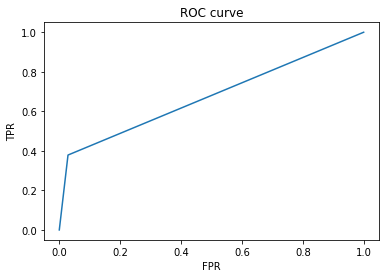

AUC Score = 67.51 %
On Model - 
Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5798
           1       0.52      0.52      0.52       792

    accuracy                           0.89      6590
   macro avg       0.73      0.73      0.73      6590
weighted avg       0.89      0.89      0.89      6590

ROC_AUC_SCORE is 0.7287661889679826


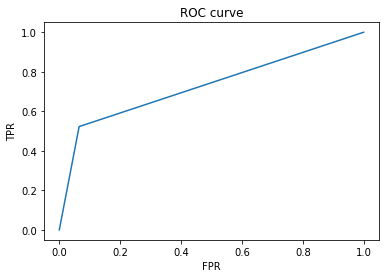

AUC Score = 72.88 %
On Model - 
Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5798
           1       0.61      0.42      0.50       792

    accuracy                           0.90      6590
   macro avg       0.77      0.69      0.72      6590
weighted avg       0.89      0.90      0.89      6590

ROC_AUC_SCORE is 0.6928627861923826


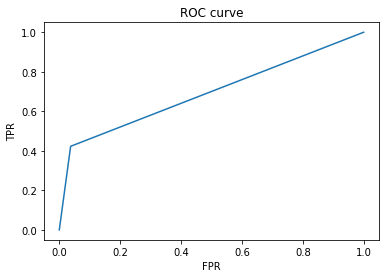

AUC Score = 69.29 %
On Model - 
Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5798
           1       0.65      0.41      0.50       792

    accuracy                           0.90      6590
   macro avg       0.79      0.69      0.72      6590
weighted avg       0.89      0.90      0.89      6590

ROC_AUC_SCORE is 0.6879912874868032


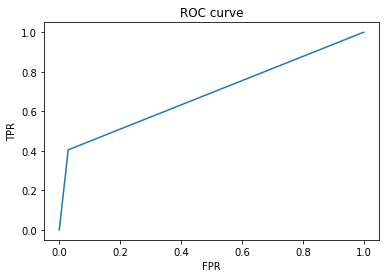

AUC Score = 68.80 %
On Model - 
XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5798
           1       0.65      0.44      0.52       792

    accuracy                           0.90      6590
   macro avg       0.79      0.70      0.73      6590
weighted avg       0.89      0.90      0.90      6590

ROC_AUC_SCORE is 0.7021356197365166


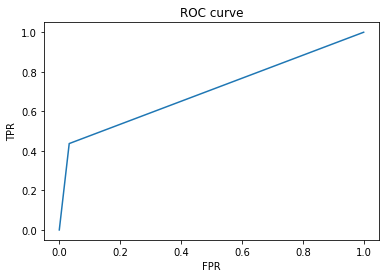

AUC Score = 70.21 %
On Model - 
Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      5798
           1       0.55      0.16      0.24       792

    accuracy                           0.88      6590
   macro avg       0.72      0.57      0.59      6590
weighted avg       0.85      0.88      0.85      6590

ROC_AUC_SCORE is 0.569572928317323


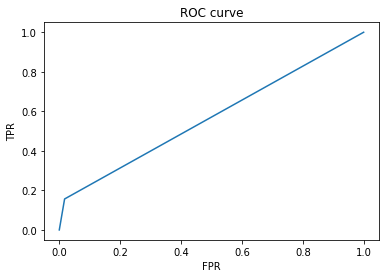

AUC Score = 56.96 %
On Model - 
SVC


In [49]:
from sklearn.model_selection import train_test_split

def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = train_test_split(predictors,target,test_size=0.2,random_state=42)
    model.fit(x_train, y_train)
    y_scores = model.predict(x_val)
    auc = roc_auc_score(y_val, y_scores)
    print('Classification Report:')
    print(classification_report(y_val,y_scores))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_scores))
    
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return auc

# Predictors
X = dataframe.iloc[:,:-1]

# Target
y = dataframe.iloc[:,-1]

models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'XGBoost':XGBClassifier,'Gradient Boosting':GradientBoostingClassifier, 'SVC':SVC}

for i in models.items():
    # run model
    model = i[1]()
    auc = run_model(X, y, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(i[0]))
    print('===='*20)

##### c) Feature selection

###### i) Using RFE

In [52]:
def feature_selection(predictors,target,number_of_features,model):

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
    plt.show()
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking)
    print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('===='*30)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {'Logistic Regression':LogisticRegression,'Random Forest':RandomForestClassifier,'XGBoost':XGBClassifier}

# Selecting 8 number of features
for i in models.items():
    feature_selection(X,y,8,i[1])

Features  to be selected for Logistic Regression are:
age               11
job                9
marital            1
education          1
default           10
housing            1
loan               7
contact            1
month              4
day_of_week        2
duration           8
campaign           1
poutcome           1
emp.var.rate       1
cons.price.idx     3
cons.conf.idx      1
euribor3m          6
nr.employed        5
dtype: int32
['marital', 'education', 'housing', 'contact', 'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx']
Features  to be selected for Random Forest are:
age                1
job                1
marital            4
education          1
default           11
housing            8
loan               9
contact           10
month              3
day_of_week        1
duration           1
campaign           1
poutcome           2
emp.var.rate       5
cons.price.idx     6
cons.conf.idx      7
euribor3m          1
nr.employed        1
dtype: int32
['age', 'job

###### ii) Using Random Forest

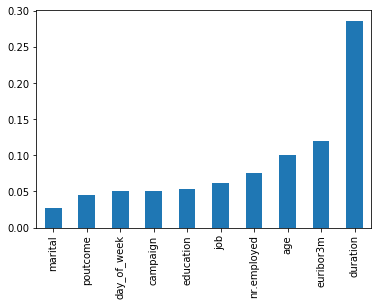

In [53]:
def rfc_feature_selection(dataset,target):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42, stratify=target)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    rfc_importances = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values().tail(10)
    rfc_importances.plot(kind='bar')
    plt.show()

rfc_feature_selection(X,y)

##### d) Grid-Search and Hyperparameter tuning

###### i) Grid Search for Random Forest and applying SMOTE for class imbalance

In [54]:
def grid_search_random_forrest(dataframe,target):

    x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_


grid_search_random_forrest(X,y)

Best Parameters are:


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2'}

On Validation data
ROC_AUC_SCORE is 0.8553937174814125
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8723
           1       0.47      0.84      0.60      1162

    accuracy                           0.87      9885
   macro avg       0.72      0.86      0.76      9885
weighted avg       0.92      0.87      0.88      9885



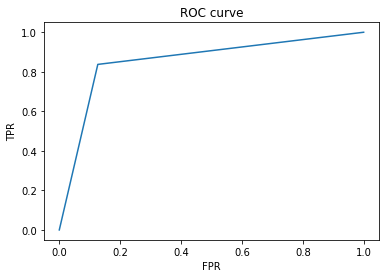

In [55]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE


def grid_search_random_forrest_best(dataframe,target):
    
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    rfc = RandomForestClassifier(n_estimators=11, max_features='log2', max_depth=8, criterion='gini',random_state=42)
    rfc.fit(X_sm, y_sm)
    y_pred = rfc.predict(x_val)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation data')
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
grid_search_random_forrest_best(X,y)

###### ii) Grid Search for Random Forest and applying SMOTE for class imbalance using features obtained from RFE

On Validation data
ROC_AUC_SCORE is 0.8632552022340686
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8723
           1       0.47      0.86      0.61      1162

    accuracy                           0.87      9885
   macro avg       0.72      0.86      0.76      9885
weighted avg       0.92      0.87      0.88      9885



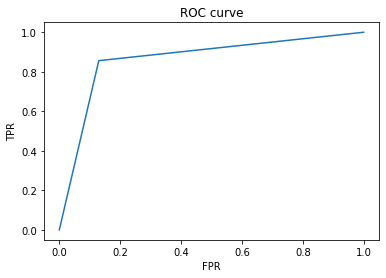

In [56]:
grid_search_random_forrest_best(X[['duration','euribor3m','age','nr.employed','job','day_of_week','campaign','education','emp.var.rate','poutcome']],y)

###### iii) Grid Search for Random Forest and applying SMOTE for class imbalance using features obtained from RandomForest

On Validation data
ROC_AUC_SCORE is 0.8451546478408023
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      8723
           1       0.46      0.82      0.59      1162

    accuracy                           0.86      9885
   macro avg       0.71      0.85      0.75      9885
weighted avg       0.91      0.86      0.88      9885



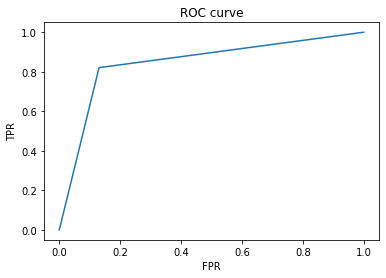

In [57]:

grid_search_random_forrest_best(X[['duration','euribor3m','age','nr.employed','job','day_of_week','campaign','education','marital','poutcome']],y)

###### iv) Grid search on Logistic Regression

On Validation Data
ROC_AUC_SCORE is  0.8553318102004651
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8723
           1       0.40      0.89      0.55      1162

    accuracy                           0.83      9885
   macro avg       0.69      0.86      0.72      9885
weighted avg       0.91      0.83      0.85      9885



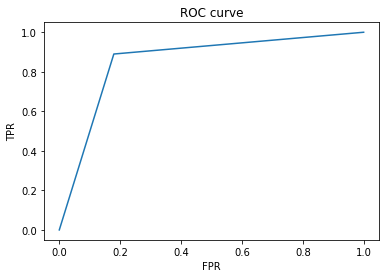

In [58]:
def grid_search_log_reg(dataframe,target):
    
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    log_reg = LogisticRegression()
    
    param_grid = { 
        'C' : np.logspace(-5, 8, 15)
    }
    grid_search = GridSearchCV(log_reg, param_grid=param_grid)
    
    grid_search.fit(X_sm, y_sm)
    y_pred = grid_search.predict(x_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('ROC_AUC_SCORE is ',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    

grid_search_log_reg(X,y)

###### v) XGBoost with SMOTE

On Validation Data
ROC_AUC_SCORE is  0.8394602632208795
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      8723
           1       0.51      0.78      0.62      1162

    accuracy                           0.89      9885
   macro avg       0.74      0.84      0.78      9885
weighted avg       0.91      0.89      0.90      9885

[[7859  864]
 [ 258  904]]


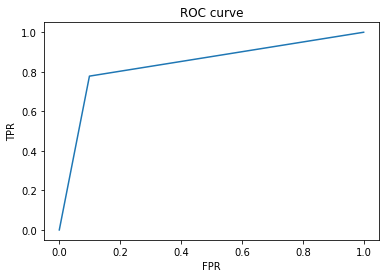

In [59]:
def xgboost(dataframe,target):
    X = dataframe
    y = target

    x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)

    model = XGBClassifier(n_estimators=50, max_depth=4)
    model.fit(pd.DataFrame(X_sm,columns=x_train.columns), y_sm)
    y_pred = model.predict(x_val)
    
    print('On Validation Data')
    print('ROC_AUC_SCORE is ', roc_auc_score(y_val, y_pred))
    print('Classification Report:')
    print(classification_report(y_val, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    #     print(auc(false_positive_rate, true_positive_rate))
    
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    print(confusion_matrix(y_val,y_pred))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
xgboost(X,y)

###### vi) Ensemble Learning

On Validation Data
AUC_ROC_SCORE is  0.8342378537914781
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      8723
           1       0.52      0.76      0.62      1162

    accuracy                           0.89      9885
   macro avg       0.74      0.83      0.77      9885
weighted avg       0.91      0.89      0.90      9885

[[7888  835]
 [ 274  888]]


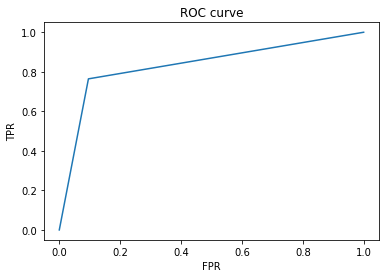

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier


def ensemble_func2(dataframe,target):
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)

    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    model1 = RandomForestClassifier()
    model3 = GradientBoostingClassifier()
    model2 = LogisticRegression()
    
    model = VotingClassifier(estimators=[('rf', model1), ('lr', model2), ('xgb',model3)], voting='soft')
    model.fit(X_sm,y_sm)
    y_pred = model.predict(x_val)
    model.score(x_val,y_val)

        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('AUC_ROC_SCORE is ',roc_auc_score(y_val, y_pred))
    print('Classification Report:')
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
ensemble_func2(X,y)

##### II) Approach 2

In [78]:
cat_cols = original_dataframe.select_dtypes(exclude=np.number)
for i in cat_cols.columns:
    print(i)
    print(original_dataframe[i].value_counts())
    print()
    print("*"*20)
    print()

job
admin.           8579
blue-collar      7441
technician       5400
services         3196
management       2345
retired          1366
entrepreneur     1160
self-employed    1099
housemaid         855
unemployed        798
student           711
Name: job, dtype: int64

********************

marital
married     20018
single       9257
divorced     3675
Name: marital, dtype: int64

********************

education
university.degree      11133
high.school             7596
basic.9y                4826
professional.course     4192
basic.4y                3322
basic.6y                1865
illiterate                16
Name: education, dtype: int64

********************

default
no     32947
yes        3
Name: default, dtype: int64

********************

housing
yes    18050
no     14900
Name: housing, dtype: int64

********************

loan
no     27927
yes     5023
Name: loan, dtype: int64

********************

contact
cellular     20908
telephone    12042
Name: contact, dtype: int64

****

###### a) Dropping Default feature as no variation in the values. One hot encoding all the categorical columns.

In [92]:
dataframe2 = original_dataframe.copy()
dataframe2.drop(['default'],1,inplace=True)

In [93]:
# Predictors
X = dataframe2.iloc[:,:-1]

# Target
y = dataframe2.iloc[:,-1]

In [94]:
X.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,49,blue-collar,married,basic.9y,no,no,cellular,nov,wed,227,4,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
1,37,entrepreneur,married,university.degree,no,no,telephone,nov,wed,202,2,failure,-0.1,93.200,-42.0,4.120,5195.8
2,55,retired,married,basic.4y,no,no,cellular,jul,mon,550,1,nonexistent,-1.7,94.215,-40.3,0.870,5008.7
3,36,admin.,married,university.degree,yes,no,telephone,may,mon,120,2,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,55,retired,divorced,university.degree,no,no,cellular,jun,tue,368,2,nonexistent,-2.9,92.963,-40.8,1.262,5076.2


In [95]:
y.head()

0     no
1     no
2    yes
3     no
4     no
Name: y, dtype: object

In [96]:
X = pd.get_dummies(X, drop_first=True)

In [97]:
X.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,49,227,4,-0.1,93.200,-42.0,4.120,5195.8,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,37,202,2,-0.1,93.200,-42.0,4.120,5195.8,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,55,550,1,-1.7,94.215,-40.3,0.870,5008.7,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,36,120,2,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,55,368,2,-2.9,92.963,-40.8,1.262,5076.2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [99]:
y = le.fit_transform(y)
y = pd.Series(y)
y.head()

0    0
1    0
2    1
3    0
4    0
dtype: int64

###### b) Normalizing data

In [100]:
from sklearn.preprocessing import MinMaxScaler

def normalizer(dataframe):
    cols = dataframe.columns
    sc = MinMaxScaler()
    dataframe = sc.fit_transform(dataframe)
    dataframe = pd.DataFrame(dataframe, columns=cols)
    return dataframe
X = normalizer(X)    
X.head()

,age,duration,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,housing_yes,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.793103,0.371595,0.75,0.651163,0.277968,0.463636,0.797456,0.852780,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.379310,0.322957,0.25,0.651163,0.277968,0.463636,0.797456,0.852780,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.000000,1.000000,0.00,0.279070,0.857306,0.618182,0.017519,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.344828,0.163424,0.25,0.930233,0.731164,0.972727,0.974322,0.830902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.000000,0.645914,0.25,0.000000,0.142694,0.572727,0.111591,0.307657,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


###### c) Applying base models

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5798
           1       0.66      0.38      0.48       792

    accuracy                           0.90      6590
   macro avg       0.79      0.68      0.72      6590
weighted avg       0.89      0.90      0.89      6590

ROC_AUC_SCORE is 0.677376124125003


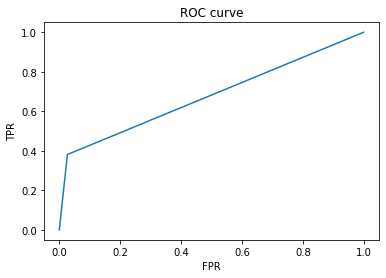

AUC Score = 67.74 %
On Model - 
Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5798
           1       0.49      0.48      0.49       792

    accuracy                           0.88      6590
   macro avg       0.71      0.71      0.71      6590
weighted avg       0.88      0.88      0.88      6590

ROC_AUC_SCORE is 0.7072982759641953


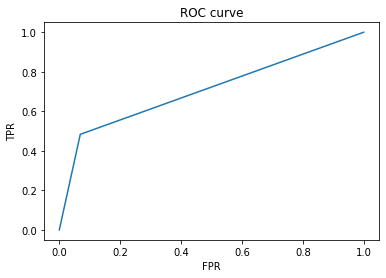

AUC Score = 70.73 %
On Model - 
Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      5798
           1       0.61      0.42      0.50       792

    accuracy                           0.90      6590
   macro avg       0.77      0.69      0.72      6590
weighted avg       0.89      0.90      0.89      6590

ROC_AUC_SCORE is 0.6926626562276786


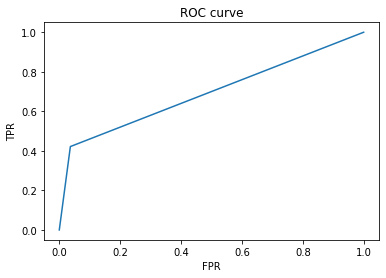

AUC Score = 69.27 %
On Model - 
Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5798
           1       0.67      0.41      0.50       792

    accuracy                           0.90      6590
   macro avg       0.80      0.69      0.73      6590
weighted avg       0.89      0.90      0.89      6590

ROC_AUC_SCORE is 0.6889398904533434


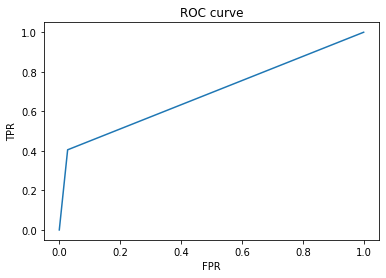

AUC Score = 68.89 %
On Model - 
XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5798
           1       0.65      0.44      0.52       792

    accuracy                           0.90      6590
   macro avg       0.79      0.70      0.74      6590
weighted avg       0.89      0.90      0.90      6590

ROC_AUC_SCORE is 0.7036569558991084


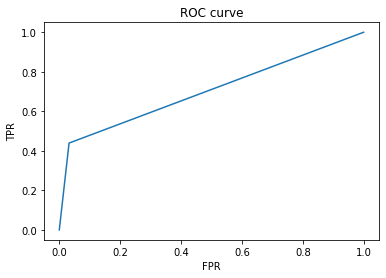

AUC Score = 70.37 %
On Model - 
Gradient Boosting
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      5798
           1       0.74      0.24      0.36       792

    accuracy                           0.90      6590
   macro avg       0.82      0.61      0.65      6590
weighted avg       0.89      0.90      0.87      6590

ROC_AUC_SCORE is 0.6124501743896363


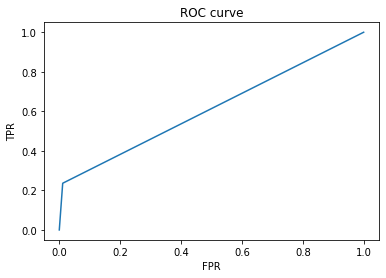

AUC Score = 61.25 %
On Model - 
SVC


In [101]:
models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'XGBoost':XGBClassifier,'Gradient Boosting':GradientBoostingClassifier, 'SVC':SVC}

for i in models.items():
    # run model
    model = i[1]()
    auc = run_model(X, y, model) # train and returns AUC test score
    print('AUC Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(i[0]))
    print('===='*20)

###### d) Feature Selection

###### i) Using RFE

In [102]:
models = {'Logistic Regression':LogisticRegression,'Random Forest':RandomForestClassifier,'XGBoost':XGBClassifier}

# Selecting 8 number of features
for i in models.items():
    feature_selection(X,y,8,i[1])

Features  to be selected for Logistic Regression are:
age                               8
duration                          1
campaign                         23
emp.var.rate                      1
cons.price.idx                    1
cons.conf.idx                    31
euribor3m                         1
nr.employed                       1
job_blue-collar                   9
job_entrepreneur                 11
job_housemaid                    34
job_management                   33
job_retired                       7
job_self-employed                19
job_services                     10
job_student                      20
job_technician                   35
job_unemployed                   22
marital_married                  37
marital_single                   25
education_basic.6y               12
education_basic.9y               24
education_high.school            30
education_illiterate              3
education_professional.course    28
education_university.degree      18
housing_ye

###### ii) Using Random Forest

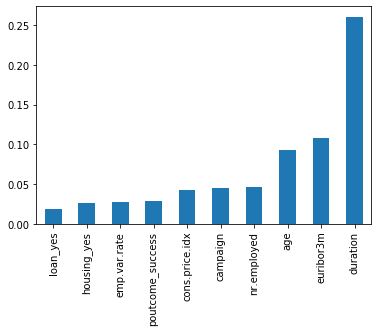

In [103]:
rfc_feature_selection(X,y)

##### e) Gird Search and Hyperparameter tuning and then applying SMOTE for class imbalance

###### i) For Random Forest

In [104]:
grid_search_random_forrest(X,y)        # Without SMOTE applying gridsearch to find best parameters

Best Parameters are:


{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt'}

On Validation data
ROC_AUC_SCORE is 0.8424056685956745
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      8723
           1       0.44      0.83      0.57      1162

    accuracy                           0.85      9885
   macro avg       0.71      0.84      0.74      9885
weighted avg       0.91      0.85      0.87      9885



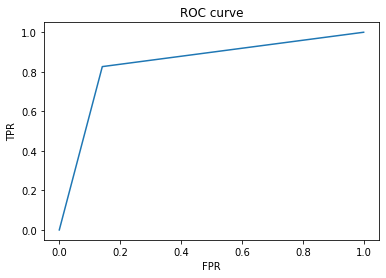

In [105]:
def grid_search_random_forrest_best(dataframe,target):
    
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    rfc = RandomForestClassifier(n_estimators=11, max_features='sqrt', max_depth=8, criterion='entropy',random_state=42)
    rfc.fit(X_sm, y_sm)
    y_pred = rfc.predict(x_val)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation data')
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
grid_search_random_forrest_best(X,y)            # Applying SMOTE

On Validation data
ROC_AUC_SCORE is 0.8617955222734998
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8723
           1       0.46      0.86      0.60      1162

    accuracy                           0.86      9885
   macro avg       0.72      0.86      0.76      9885
weighted avg       0.92      0.86      0.88      9885



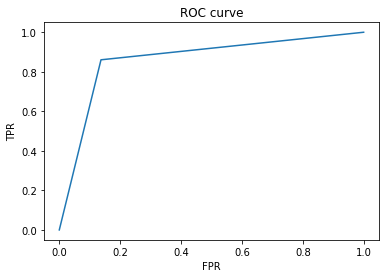

In [106]:
# Random Forest with best features using RFE
grid_search_random_forrest_best(X[['age', 'duration', 'campaign', 'cons.price.idx', 'euribor3m', 'nr.employed', 'education_university.degree', 'housing_yes']],y)

###### ii) For Logistic Regression

On Validation Data
ROC_AUC_SCORE is  0.860032028015437
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      8723
           1       0.41      0.89      0.56      1162

    accuracy                           0.84      9885
   macro avg       0.70      0.86      0.73      9885
weighted avg       0.92      0.84      0.86      9885



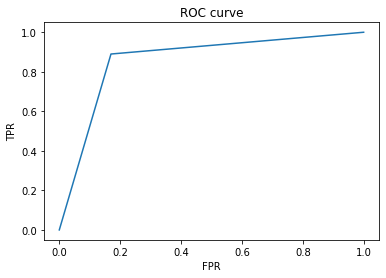

In [107]:
## Applying SMOTE + GridSearchcv
grid_search_log_reg(X,y)

On Validation Data
ROC_AUC_SCORE is  0.8596080494658414
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      8723
           1       0.40      0.90      0.55      1162

    accuracy                           0.83      9885
   macro avg       0.69      0.86      0.72      9885
weighted avg       0.92      0.83      0.85      9885



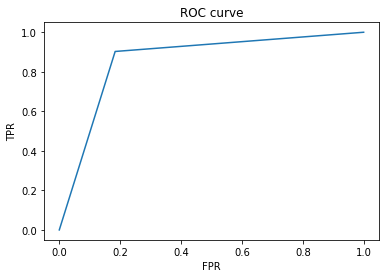

In [108]:
## Logistic regression using best features selected by RFE
grid_search_log_reg(X[['duration', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed', 'month_mar', 'month_may', 'poutcome_success']],y)

###### iii) Using XGBoost

On Validation Data
ROC_AUC_SCORE is  0.8645516048241705
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8723
           1       0.45      0.87      0.59      1162

    accuracy                           0.86      9885
   macro avg       0.72      0.86      0.75      9885
weighted avg       0.92      0.86      0.88      9885

[[7486 1237]
 [ 150 1012]]


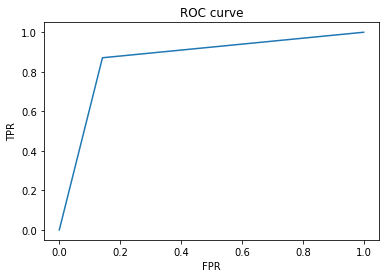

In [109]:
xgboost(X,y)

###### iv) Ensembling

On Validation Data
AUC_ROC_SCORE is  0.8563657851135632
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8723
           1       0.48      0.83      0.61      1162

    accuracy                           0.87      9885
   macro avg       0.73      0.86      0.77      9885
weighted avg       0.92      0.87      0.89      9885

[[7681 1042]
 [ 195  967]]


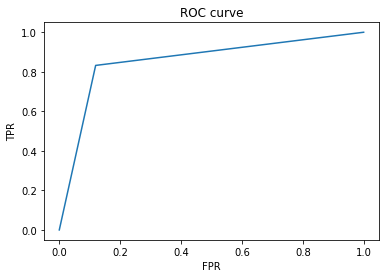

In [110]:
ensemble_func2(X,y)